In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from __future__ import absolute_import, division, print_function


# TensorFlow and tf.keras

import pandas as pd


processed_data = np.load('Full_array.npy')
Blue_processed_data = np.load('Blue_Full_array.npy')
Red_processed_data = np.load("RED_Full_array.npy")
#The size of the dataset is 10,000; but I only filled the first 9166 with values, the rest are zeros. (shouldn't be counted)
number = 9166
processed_data = processed_data[0:number]

#np.random.seed(1)


In [3]:
from PIL import Image
from cv2 import resize
from sklearn.utils import shuffle

In [4]:
import tensorflow as tf
from tensorflow import keras

In [5]:
#hyperparameters:
test_train_split = 0.75
batch_size = 64
epoch_number = 100
validation_split = 0.15
learning_rate = 2e-6
dropout_rate = 0.45
CNL1_filters = 32
CNL1_kernal_size = 5
MPL1_pool_size= (2,2)
MPL1_strides = 2
CNL2_filters = 64
CNL2_kernal_size = 5
MPL2_pool_size = (2,2)
MPL2_strides = 2

In [6]:
#I have a non-round number of examples
train_split_indice = int(np.round(test_train_split*number))

In [7]:
#Load in my dataset of targets, targets are strings labels under the name "Class"
galaxyzoo = pd.read_csv("zoo2MainSpecz.csv/zoo2MainSpecz.csv", usecols=[2,3,4,8,15,21,27], nrows=number)
#galaxyzoo = pd.read_csv("zoo2MainSpecz.csv/zoo2MainSpecz.csv", nrows=number)
Class = galaxyzoo["gz2class"].values
RA = galaxyzoo['ra'].values
DEC = galaxyzoo['dec'].values
#Spiral = galaxyzoo['t01_smooth_or_features_a02_features_or_disk_debiased'].values
#Elliptical = galaxyzoo['t01_smooth_or_features_a01_smooth_debiased'].values
#Anythingelse = galaxyzoo['t01_smooth_or_features_a03_star_or_artifact_debiased'].values

In [8]:
#I want to take the first character of the Class string and interpret as a integer, ala MNIST example code
dictionary = {'A':int(2),'E':int(1),'S':int(0)}

In [9]:
#resave using my dictionary
target = np.empty((len(Class)))
for i in range(len(Class)):
    target[i] = int(dictionary[Class[i][0]])

In [10]:
#split my data between training and test sets
train_target = target[0:train_split_indice]
test_target = target[train_split_indice:number]
train_images = processed_data[0:train_split_indice]
test_images = processed_data[train_split_indice:number]
Blue_train_images = Blue_processed_data[0:train_split_indice]
Blue_test_images = Blue_processed_data[train_split_indice::]
Red_train_images = Red_processed_data[0:train_split_indice]
Red_test_images = Red_processed_data[train_split_indice::]

In [11]:
#reform into the tensor shape
train_images_number = np.shape(train_images)[0]
test_images_number = np.shape(test_images)[0]
train_images = train_images.reshape(train_images_number,28,28,1)
test_images = test_images.reshape(test_images_number,28,28,1)
Blue_train_images = Blue_train_images.reshape(train_images_number,28,28,1)
Blue_test_images = Blue_test_images.reshape(test_images_number,28,28,1)
Red_train_images = Red_train_images.reshape(train_images_number,28,28,1)
Red_test_images = Red_test_images.reshape(test_images_number,28,28,1)

In [12]:
#shuffle the order of the augmented images randomly, shuffle the order of the targets the same way.
#train_images, train_target = shuffle(train_images, train_target, random_state=1)

In [13]:
#Seems I need to pad the arrays with zeros to get to 32x32, then copy the values of the first monochromatic channel into 3 channels
#to use tranfer learning
print(np.shape(train_images))

train_images_middle_step = np.append(Red_train_images, train_images, 3)
train_images = np.append(train_images_middle_step, Blue_train_images, 3)

test_images_middle_step = np.append(Red_test_images,test_images, 3)
test_images = np.append(test_images_middle_step,Blue_test_images, 3)

print(np.shape(test_images))
print(np.shape(train_images))

#consider saving this array in the future instead of wasting time re-running

(6874, 28, 28, 1)
(2292, 28, 28, 3)
(6874, 28, 28, 3)


In [14]:
#define my model, using a CNN with 2 Convolutional layers, 2 max pool layers, 1 dense layer, 1 drop out layer, and another dense layer 
def create_model(dropout_rate=dropout_rate, learning_rate=learning_rate):
    
    model = keras.Sequential([])
    model.add(keras.layers.Conv2D(input_shape=(28,28,3),filters=CNL1_filters,kernel_size=CNL1_kernal_size,padding="same",activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(pool_size=MPL1_pool_size, strides=MPL1_strides))
    model.add(keras.layers.Conv2D(filters=CNL2_filters,kernel_size=CNL2_kernal_size,padding="same",activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(pool_size=MPL2_pool_size,strides=MPL2_strides))
    model.add(keras.layers.Reshape([7*7*64]))
    model.add(keras.layers.Dense(units=1024,activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=dropout_rate))
    model.add(keras.layers.Dense(units=3,activation=tf.nn.softmax))
    adam = keras.optimizers.Adam(lr = learning_rate)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return(model)

In [15]:
#lets try training one epoch at a time and seeing what epoch when we maximize our accuracy; I fear overtraining

#OTHER than that, my next idea is to change the architecture.... eventually I will need to build a RESnet anyways
model = create_model(dropout_rate=dropout_rate, learning_rate = learning_rate)
history = model.fit(train_images, train_target, epochs=epoch_number,validation_split=validation_split, batch_size=batch_size, verbose=1, shuffle=True)

Train on 5842 samples, validate on 1032 samples
Epoch 1/100
5842/5842 [==============================] - 28s 5ms/sample - loss: 1.0574 - accuracy: 0.4772 - val_loss: 0.7542 - val_accuracy: 0.6938
Epoch 2/100
5842/5842 [==============================] - 24s 4ms/sample - loss: 0.8468 - accuracy: 0.5810 - val_loss: 0.6876 - val_accuracy: 0.7180
Epoch 3/100
5842/5842 [==============================] - 24s 4ms/sample - loss: 0.7889 - accuracy: 0.6138 - val_loss: 0.6533 - val_accuracy: 0.7384
Epoch 4/100
5842/5842 [==============================] - 21s 4ms/sample - loss: 0.7495 - accuracy: 0.6409 - val_loss: 0.6326 - val_accuracy: 0.7384
Epoch 5/100
5842/5842 [==============================] - 20s 3ms/sample - loss: 0.7436 - accuracy: 0.6434 - val_loss: 0.6188 - val_accuracy: 0.7432
Epoch 6/100
5842/5842 [==============================] - 19s 3ms/sample - loss: 0.7194 - accuracy: 0.6489 - val_loss: 0.6101 - val_accuracy: 0.7413
Epoch 7/100
5842/5842 [==============================] - 20s 3ms

Epoch 56/100
5842/5842 [==============================] - 19s 3ms/sample - loss: 0.5442 - accuracy: 0.7636 - val_loss: 0.5456 - val_accuracy: 0.7510
Epoch 57/100
5842/5842 [==============================] - 19s 3ms/sample - loss: 0.5405 - accuracy: 0.7617 - val_loss: 0.5462 - val_accuracy: 0.7510
Epoch 58/100
5842/5842 [==============================] - 19s 3ms/sample - loss: 0.5439 - accuracy: 0.7621 - val_loss: 0.5420 - val_accuracy: 0.7539
Epoch 59/100
5842/5842 [==============================] - 19s 3ms/sample - loss: 0.5421 - accuracy: 0.7667 - val_loss: 0.5428 - val_accuracy: 0.7510
Epoch 60/100
5842/5842 [==============================] - 19s 3ms/sample - loss: 0.5442 - accuracy: 0.7631 - val_loss: 0.5423 - val_accuracy: 0.7568
Epoch 61/100
5842/5842 [==============================] - 19s 3ms/sample - loss: 0.5365 - accuracy: 0.7662 - val_loss: 0.5408 - val_accuracy: 0.7558
Epoch 62/100
5842/5842 [==============================] - 19s 3ms/sample - loss: 0.5372 - accuracy: 0.7667

In [16]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


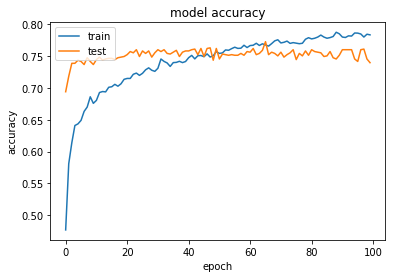

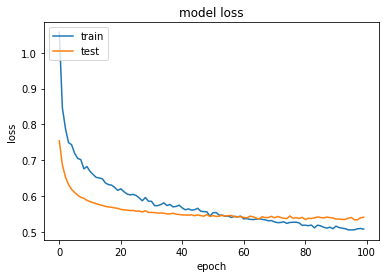

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('CNN_Learning_GZ2_4_26_19_epoch40_acc.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('CNN_Learning_GZ2_4_26_19_epoch40_loss.png')
plt.show()

In [18]:
#model.summary()
test_loss, test_acc = model.evaluate(test_images, test_target)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

#High variability in my loss metric resulted in random flutuations. However, my test set scores just as well as my validation
#which is worrying. It either means I am over training on my first set, or my LR is too high. Lr not clear what was set to. 
#maybe 3e-5?

#setting lr to 3e-9 to reduce volatility. not learning enough. hard to gauge volatility when nothing learned

#setting lr 3e-7 to increase learning. volatility decresed significantly training wasnt saturated with only 50 epochs bringing 
#train learning to ~.70. validation was higher than train accuracy(????) and at ~.75?

#increasing lr to 1e-6, otherwise may go back to 3e-7 and run more epochs. loss seemed to converge, but very weird that it was so
#low.

#lr= 1e-6 worked, but I am getting low accuracy... I am going to change dropout from 0.45 to 0.3, batch size from 32 to 16, and
#lr to 1e-5. if that is volatile, I will consider moving back to lr=1e-6 and run more epochs. I am very sure that I am getting
#stuck in a local minimum because before with the higher LR my train accuracy was at 0.9 after 50 epochs, now i'm only getting to
#0.74 and seemingly converging...

#okay something is wrong with lr=1e-5, dropout=0.25, batch_size=16 ... lets set that lr lower...

# at 7e-6, the training score increased to an accuracy of 85, but the validation didnt increase past 0.75. I think I need to 
#lower the LR a bit more. trying 3e-6.

#3e-6 did the same as 7e-6: loss quickly went to 0.54-55 and acuracy flutters around 0.7-.75... lowering lr to 1e-6

#lowering to 1e-6 and training for 100 epochs, I seemed to have begun to overtrain around epoch 25. There seems to be more
#potential for more epochs as well, my training set loss continues to linearly fall, its just that the validation doesn't follow
#I will move to slightly increase dropout from 0.4 to 0.45, increase batch size from 16 to 64, and increase lr to 2e-6 to combat
#overtraining. after I will consider running for a really giant amount of epochs, then move to transfer learning.

#neat, it improved a little bit, definitely only began overtraining at epoch ~90 instead of ~25... however, accuracy is not 
#improving still. 

2292/2292 [==============================] - 2s 927us/sample - loss: 0.5477 - accuracy: 0.7557
Test accuracy: 0.7556719
Test loss: 0.5476913705962283


<b>Update (5/11/19)</b>Not sure what to make of this; I concluded that to push my accuracy higher I might need a better dataset, which is where I let off to try and query skyview for a better one.

<img src='CNN_Learning_GZ2_4_26_19_epoch40_acc.png'>

<img src='CNN_Learning_GZ2_4_26_19_epoch40_loss.png'>